In [1]:
# Import necessary libraries for wandb data retrieval and analysis
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Kang

In [2]:

# Initialize API
api = wandb.Api()

# Method 1: Get sweep object first
sweep_ids = ["g8povs27", "fymvd3ew", "5tj444h1", "ybds4iut", "gxlld5l2", "rnbneqke", "lf58ioxv"] # This is with concept_hp=0.01 for CBM-based models
sweep_ids = ["0ndnusil", "fymvd3ew", "5tj444h1", "cdv2yyo6", "gxlld5l2", "rnbneqke", "lf58ioxv","b2eoxdr2"] # This is with concept_hp=0.1 for CBM-based models

entity = "debroue1"  # your username or team name
project = "conceptlab"

dfs = []
for sweep_id in sweep_ids:
    sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

    runs = sweep.runs
    # Get all runs from the sweep
    runs_dict = []
    for run in runs:
        mmd_ratio = run.summary.get("mmd_ratio",np.nan)
        emd_ratio = run.summary.get("emd_ratio",np.nan)
        recall_negs = run.summary.get("recall_negs", np.nan)
        recall_pos = run.summary.get("recall_pos", np.nan)
        runs_dict.append({**run.config, 
                          "mmd_ratio": mmd_ratio,
                          "emd_ratio": emd_ratio,
                          "recall_negs": recall_negs,
                          "recall_pos": recall_pos,
                          "sweep": sweep_id,})
    df_sweep = pd.DataFrame(runs_dict)
    dfs.append(df_sweep)
df_res = pd.concat(dfs, ignore_index=True)

In [3]:
df_res["recall_avg"] = df_res[["recall_negs","recall_pos"]].mean(1)

In [4]:
model_dict = {"cbm": "CBM",
              "cbmfm": "CBM-FM",
              "cbmfm_raw": "CellFlow",
              "conceptflow": "ConceptFlow",
              "cinemaot": "Cinema-OT",
              "scgen": "SCGen",
              "biolord": "Biolord",
              "cem_vae": "CEM-VAE"}

ct_dict = {
    'cd4': 'CD4 T cells',
    'cd4_cd25': "CD4/CD25 T cells",
    'cd4_naive': "CD4 naive T cells",
    'nk': 'NK cells',
    'bcells': 'B cells',
    'bcells_germinal': "B cells (germinal)",
    'bcells_memory': "B cells (memory)",
    'cd8_tcells': 'CD8 T cells',
    'cd14_monocytes': 'CD14 Monocytes',
    'dendritic_cells': 'Dendritic Cells',
    'fcgr3a_monocytes': 'FCGR3A Monocytes',
    'megakaryocytes': 'Megakaryocytes'
}

df_res["model"] = df_res["model"].map(model_dict)
#df_res["data/intervention_labels"] = df_res["data/intervention_labels"].map(ct_dict)

## Plots for all models

Choose model configurations (eg PCA, no PCA) and metric name


Metric names:
- recall_avg
- mmd_ratio

In [5]:
# Processing the edit and decode versions of the FM models
df_res["edit_str"] = ""
df_res.loc[df_res["model.edit"]==True, "edit_str"] = " (edit)"
df_res.loc[df_res["model.edit"]==False, "edit_str"] = " (decode)"
df_res["model"] = df_res["model"] + df_res["edit_str"]

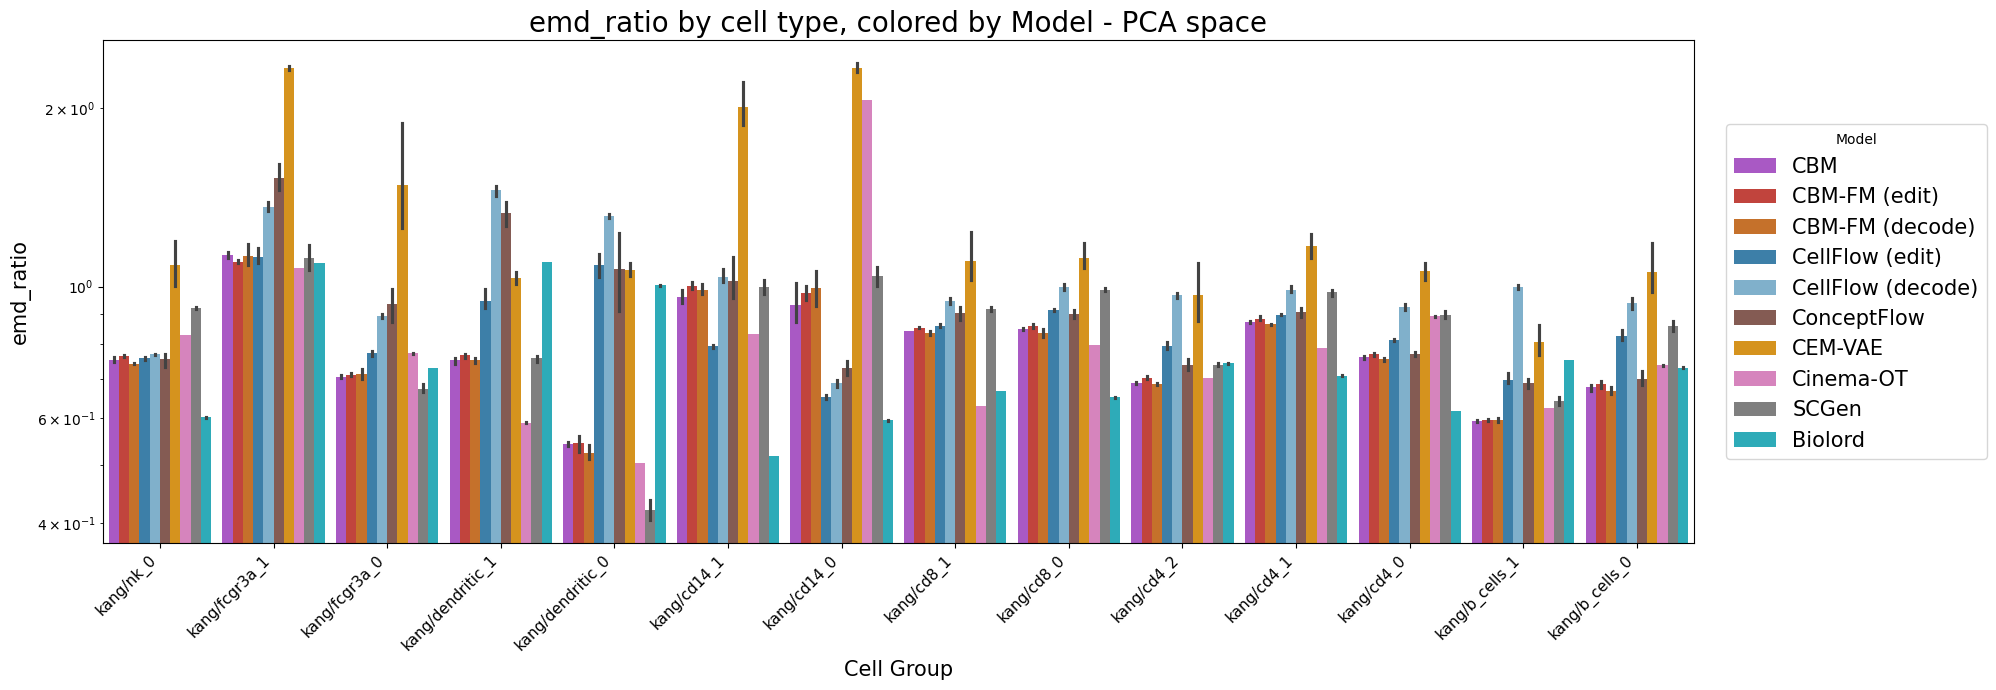

In [8]:
metric_name = 'emd_ratio'


# Barplot: 4 bars for each cell type (one per model), aggregation over seeds, with error bars, larger font, and tilted x labels
import matplotlib.pyplot as plt
import seaborn as sns

# Check required columns
required_cols = ['data/intervention_labels', 'model', 'seed', metric_name]
missing = [col for col in required_cols if col not in df_res.columns]
if missing:
    raise ValueError(f"Missing columns in df_res: {missing}")

# Aggregate over seeds: mean and std of mmd_ratio for each (cell type, model) pair
model_order = ["CBM", "CBM-FM (edit)", "CBM-FM (decode)", "CellFlow (edit)", "CellFlow (decode)",  "ConceptFlow","CEM-VAE", "Cinema-OT", "SCGen", "Biolord"]

color_map = {
    "CBM": "#b247d6",                     # purple
    "CBM-FM (edit)": "#d73027",           # red (edit)
    "CBM-FM (decode)": "#df6e11",         # orange-red (decode)
    "CellFlow (edit)": "#2b83ba",         # blue (edit)
    "CellFlow (decode)": "#73b3d8",       # lighter blue (decode)
    "ConceptFlow": "#8c564b",             # brownish
    "Cinema-OT": "#e377c2",               # pink
    "SCGen": "#7f7f7f",                   # gray
    "Biolord": "#17becf",                 # teal
    "CEM-VAE": "#f39b00",                 # yellow-orange
}
# Keep only colors for models present
palette = {k: v for k, v in color_map.items() if k in model_order}


plt.figure(figsize=(20,7))
ax = sns.barplot(
    data=df_res,
    x='data/intervention_labels',
    y=metric_name,
    estimator="mean",
    hue='model',
    hue_order = model_order,
    palette=palette,
    width=0.9,
    dodge = True,
 )
ax.set_yscale('log')
plt.title(f'{metric_name} by cell type, colored by Model - PCA space', fontsize=20)
plt.ylabel(f'{metric_name}', fontsize=15)
plt.xlabel('Cell Group', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=11)

# place legend to the right, outside the plot
n_models = df_res['model'].nunique()
ncol = 1  # single column legend on the right
leg = ax.legend(title='Model', fontsize=15, ncol=ncol,
                loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)

# make room on the right for the legend
fig = ax.get_figure()
fig.subplots_adjust(right=0.75)  # reduce to e.g. 0.75 or 0.7 depending on legend width

plt.tight_layout()
plt.show()

In [7]:
df_res.to_csv("./results_kang.csv", index=False)

### DE recall

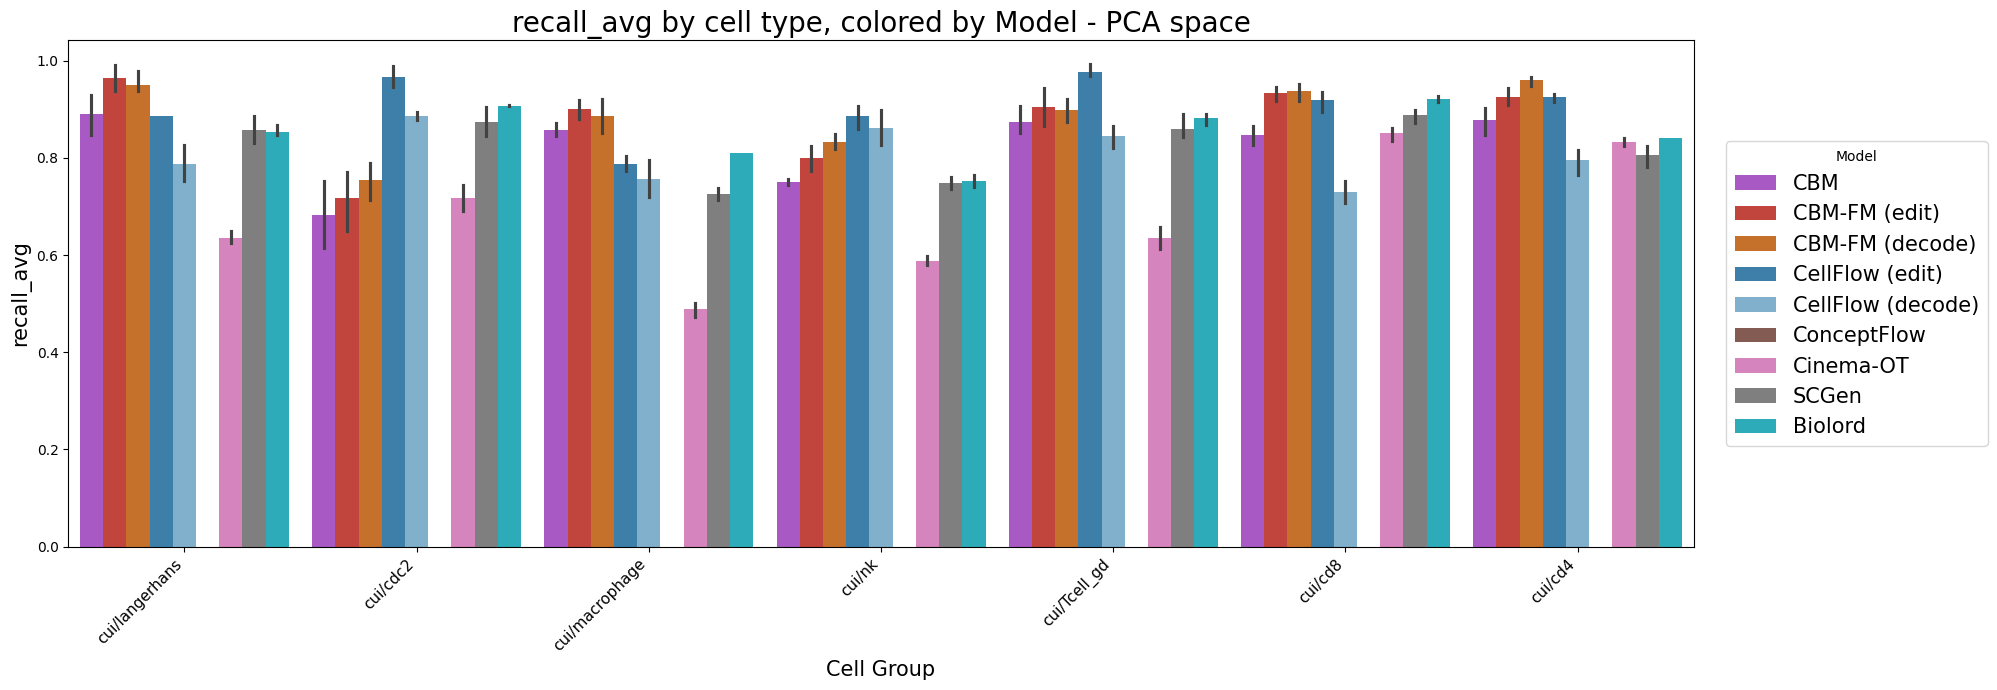

In [9]:
metric_name = 'recall_avg'


# Barplot: 4 bars for each cell type (one per model), aggregation over seeds, with error bars, larger font, and tilted x labels
import matplotlib.pyplot as plt
import seaborn as sns

# Check required columns
required_cols = ['data/intervention_labels', 'model', 'seed', metric_name]
missing = [col for col in required_cols if col not in df_res.columns]
if missing:
    raise ValueError(f"Missing columns in df_res: {missing}")

# Aggregate over seeds: mean and std of mmd_ratio for each (cell type, model) pair
model_order = ["CBM", "CBM-FM (edit)", "CBM-FM (decode)", "CellFlow (edit)", "CellFlow (decode)",  "ConceptFlow", "Cinema-OT", "SCGen", "Biolord"]

color_map = {
    "CBM": "#b247d6",                     # purple
    "CBM-FM (edit)": "#d73027",           # red (edit)
    "CBM-FM (decode)": "#df6e11",         # orange-red (decode)
    "CellFlow (edit)": "#2b83ba",         # blue (edit)
    "CellFlow (decode)": "#73b3d8",       # lighter blue (decode)
    "ConceptFlow": "#8c564b",             # brownish
    "Cinema-OT": "#e377c2",               # pink
    "SCGen": "#7f7f7f",                   # gray
    "Biolord": "#17becf",                 # teal
    "CEM-VAE": "#f39b00",                 # yellow-orange
}
# Keep only colors for models present
palette = {k: v for k, v in color_map.items() if k in model_order}


plt.figure(figsize=(20,7))
ax = sns.barplot(
    data=df_res,
    x='data/intervention_labels',
    y=metric_name,
    estimator="mean",
    hue='model',
    hue_order = model_order,
    palette=palette,
    width=0.9,
    dodge = True,
 )
plt.title(f'{metric_name} by cell type, colored by Model - PCA space', fontsize=20)
plt.ylabel(f'{metric_name}', fontsize=15)
plt.xlabel('Cell Group', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=11)

# place legend to the right, outside the plot
n_models = df_res['model'].nunique()
ncol = 1  # single column legend on the right
leg = ax.legend(title='Model', fontsize=15, ncol=ncol,
                loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)

# make room on the right for the legend
fig = ax.get_figure()
fig.subplots_adjust(right=0.75)  # reduce to e.g. 0.75 or 0.7 depending on legend width

plt.tight_layout()
plt.show()

# Cui

In [15]:
# Initialize API
api = wandb.Api()

# Method 1: Get sweep object first
sweep_ids = ["uqmtedd2", "zcpmq6vp", "b9ulfnyk", "td69wh8c"]
sweep_ids = ["jo959g2b", "m3y5vaet", "s1gps1cz", "cia8lm8g", "yiq35p37","y65js1pa", "4iflyw18"]
entity = "debroue1"  # your username or team name
project = "conceptlab"

dfs = []
for sweep_id in sweep_ids:
    sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

    runs = sweep.runs
    # Get all runs from the sweep
    runs_dict = []
    for run in runs:
        mmd_ratio = run.summary.get("mmd_ratio",np.nan)
        emd_ratio = run.summary.get("emd_ratio",np.nan)
        recall_negs = run.summary.get("recall_negs", np.nan)
        recall_pos = run.summary.get("recall_pos", np.nan)
        runs_dict.append({**run.config, 
                          "mmd_ratio": mmd_ratio,
                          "emd_ratio": emd_ratio,
                          "recall_negs": recall_negs,
                          "recall_pos": recall_pos})
    df_sweep = pd.DataFrame(runs_dict)
    dfs.append(df_sweep)
df_res = pd.concat(dfs, ignore_index=True)

In [16]:
df_res["recall_avg"] = df_res[["recall_negs","recall_pos"]].mean(1)

In [17]:
model_dict = {"cbm": "CBM",
              "cbmfm": "CBM-FM",
              "cbmfm_raw": "CellFlow",
              "conceptflow": "ConceptFlow",
              "cinemaot": "Cinema-OT",
              "scgen": "SCGen",
              "biolord": "Biolord",
              "cem_vae": "CEM-VAE"}

df_res["model"] = df_res["model"].map(model_dict)

## Plots

In [18]:
# Processing the edit and decode versions of the FM models
df_res["edit_str"] = ""
df_res.loc[df_res["model.edit"]==True, "edit_str"] = " (edit)"
df_res.loc[df_res["model.edit"]==False, "edit_str"] = " (decode)"
df_res["model"] = df_res["model"] + df_res["edit_str"]

In [19]:
df_res

,data,seed,model,data/intervention_labels,mmd_ratio,emd_ratio,recall_negs,recall_pos,model.cbm_config.concepts_hp,model.edit,model.cbm_mod.cbm_config.concepts_hp,model.lr,recall_avg,edit_str
0,cui,69,Biolord,cui/langerhans,2.749152,0.732748,0.722222,0.970149,NaN,NaN,NaN,NaN,0.846186,
1,cui,1337,Biolord,cui/langerhans,2.747645,0.732555,0.722222,0.970149,NaN,NaN,NaN,NaN,0.846186,
2,cui,42,Biolord,cui/langerhans,2.753168,0.732603,0.777778,0.970149,NaN,NaN,NaN,NaN,0.873964,
3,cui,13,Biolord,cui/langerhans,2.752192,0.733148,0.722222,0.970149,NaN,NaN,NaN,NaN,0.846186,
4,cui,69,Biolord,cui/cdc2,3.423756,0.847286,0.846154,0.971429,NaN,NaN,NaN,NaN,0.908791,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,cui,1337,CEM-VAE,cui/cd8,0.388602,0.603908,0.707317,1.000000,0.1,NaN,NaN,NaN,0.853659,
248,cui,13,CEM-VAE,cui/cd8,0.349430,0.603134,0.658537,1.000000,0.1,NaN,NaN,NaN,0.829268,
249,cui,42,CEM-VAE,cui/cd4,0.068464,0.632296,0.750000,1.000000,0.1,NaN,NaN,NaN,0.875000,
250,cui,1337,CEM-VAE,cui/cd4,0.246270,0.693070,0.681818,0.944444,0.1,NaN,NaN,NaN,0.813131,


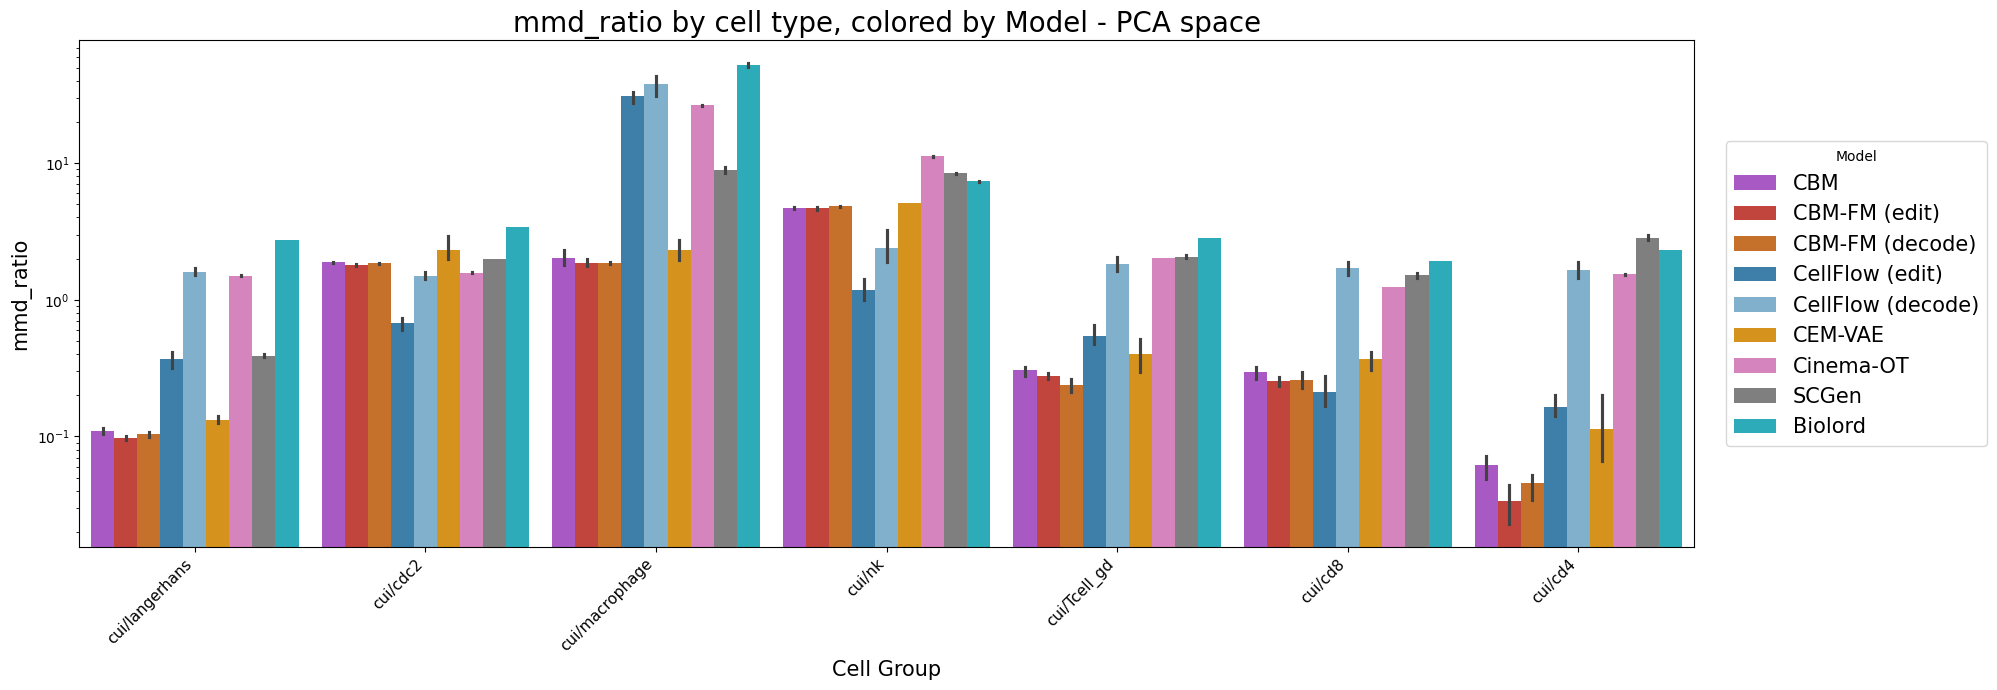

In [20]:
metric_name = 'mmd_ratio'


# Barplot: 4 bars for each cell type (one per model), aggregation over seeds, with error bars, larger font, and tilted x labels
import matplotlib.pyplot as plt
import seaborn as sns

# Check required columns
required_cols = ['data/intervention_labels', 'model', 'seed', metric_name]
missing = [col for col in required_cols if col not in df_res.columns]
if missing:
    raise ValueError(f"Missing columns in df_res: {missing}")

# Aggregate over seeds: mean and std of mmd_ratio for each (cell type, model) pair
model_order = ["CBM", "CBM-FM (edit)", "CBM-FM (decode)", "CellFlow (edit)", "CellFlow (decode)", "CEM-VAE","Cinema-OT", "SCGen", "Biolord"]

color_map = {
    "CBM": "#b247d6",                     # purple
    "CBM-FM (edit)": "#d73027",           # red (edit)
    "CBM-FM (decode)": "#df6e11",         # orange-red (decode)
    "CellFlow (edit)": "#2b83ba",         # blue (edit)
    "CellFlow (decode)": "#73b3d8",       # lighter blue (decode)
    "ConceptFlow": "#8c564b",             # brownish
    "Cinema-OT": "#e377c2",               # pink
    "SCGen": "#7f7f7f",                   # gray
    "Biolord": "#17becf",                 # teal
    "CEM-VAE": "#f39b00",                 # yellow-orange
}
# Keep only colors for models present
palette = {k: v for k, v in color_map.items() if k in model_order}


plt.figure(figsize=(20,7))
ax = sns.barplot(
    data=df_res,
    x='data/intervention_labels',
    y=metric_name,
    estimator="mean",
    hue='model',
    hue_order = model_order,
    palette=palette,
    width=0.9,
    dodge = True,
 )
ax.set_yscale('log')
plt.title(f'{metric_name} by cell type, colored by Model - PCA space', fontsize=20)
plt.ylabel(f'{metric_name}', fontsize=15)
plt.xlabel('Cell Group', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=11)

# place legend to the right, outside the plot
n_models = df_res['model'].nunique()
ncol = 1  # single column legend on the right
leg = ax.legend(title='Model', fontsize=15, ncol=ncol,
                loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)

# make room on the right for the legend
fig = ax.get_figure()
fig.subplots_adjust(right=0.75)  # reduce to e.g. 0.75 or 0.7 depending on legend width

plt.tight_layout()
plt.show()

In [21]:
df_res.to_csv("results_cui.csv", index=False)

In [9]:
min_mmd_per_intervention = df_res.groupby(["model","data/intervention_labels"])["mmd_ratio"].mean().reset_index().groupby("data/intervention_labels")["mmd_ratio"].min()
df_res_sub = df_res[df_res["data/intervention_labels"].isin(min_mmd_per_intervention.index[(min_mmd_per_intervention<1)].tolist())]

In [12]:
metric_name = 'mmd_ratio'


# Barplot: 4 bars for each cell type (one per model), aggregation over seeds, with error bars, larger font, and tilted x labels
import matplotlib.pyplot as plt
import seaborn as sns

# Check required columns
required_cols = ['data/intervention_labels', 'model', 'seed', metric_name]
missing = [col for col in required_cols if col not in df_res.columns]
if missing:
    raise ValueError(f"Missing columns in df_res: {missing}")

# Aggregate over seeds: mean and std of mmd_ratio for each (cell type, model) pair
model_order = ["CBM", "CBM-FM (edit)", "CBM-FM (decode)", "CellFlow (edit)", "CellFlow (decode)", "CEM-VAE", "Cinema-OT", "SCGen", "Biolord"]

color_map = {
    "CBM": "#b247d6",                     # purple
    "CBM-FM (edit)": "#d73027",           # red (edit)
    "CBM-FM (decode)": "#df6e11",         # orange-red (decode)
    "CellFlow (edit)": "#2b83ba",         # blue (edit)
    "CellFlow (decode)": "#73b3d8",       # lighter blue (decode)
    "ConceptFlow": "#8c564b",             # brownish
    "Cinema-OT": "#e377c2",               # pink
    "SCGen": "#7f7f7f",                   # gray
    "Biolord": "#17becf",                 # teal
}
# Keep only colors for models present
palette = {k: v for k, v in color_map.items() if k in model_order}


plt.figure(figsize=(20,7))
ax = sns.barplot(
    data=df_res_sub,
    x='data/intervention_labels',
    y=metric_name,
    estimator="mean",
    hue='model',
    hue_order = model_order,
    palette=palette,
    width=0.9,
    dodge = True,
 )
ax.set_yscale('log')
plt.title(f'{metric_name} by cell type, colored by Model - PCA space', fontsize=20)
plt.ylabel(f'{metric_name}', fontsize=15)
plt.xlabel('Cell Group', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=11)

# place legend to the right, outside the plot
n_models = df_res['model'].nunique()
ncol = 1  # single column legend on the right
leg = ax.legend(title='Model', fontsize=15, ncol=ncol,
                loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)

# make room on the right for the legend
fig = ax.get_figure()
fig.subplots_adjust(right=0.75)  # reduce to e.g. 0.75 or 0.7 depending on legend width

plt.tight_layout()
plt.show()

NameError: name 'df_res_sub' is not defined

<Figure size 2000x700 with 0 Axes>

In [2]:
import anndata as ad
adata = ad.read_h5ad("/braid/havivd/immune_dictionary/lig_seurat_with_concepts_v2.h5ad")

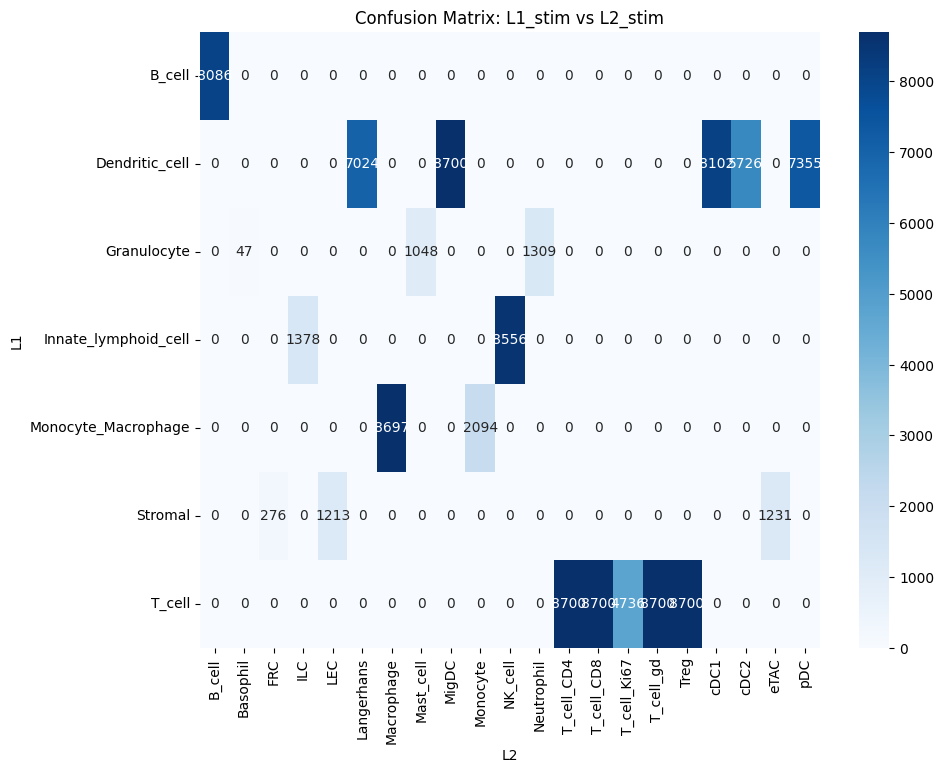

In [ ]:
# Confusion matrix for L1_stim vs L2_stim
confusion_matrix = adata.obs.groupby(["cell_type_L1","cell_type_L2"]).size().unstack(fill_value=0)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: L1_stim vs L2_stim')
plt.ylabel('L1')
plt.xlabel('L2')
plt.show()

In [12]:
adata.obs.groupby(["L1_stim","L2_stim"]).size()

L1_stim       L2_stim           
B_cell_41BBL  B_cell_41BBL          40
              B_cell_APRIL           0
              B_cell_Adiponectin     0
              B_cell_BAFF            0
              B_cell_C3a             0
                                    ..
T_cell_VEGF   pDC_TPO                0
              pDC_TRAIL              0
              pDC_TSLP               0
              pDC_TWEAK              0
              pDC_VEGF               0
Length: 1074276, dtype: int64

In [11]:
adata.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'channel', 'nCount_HTO',
       'nFeature_HTO', 'MULTI_ID', 'MULTI_classification', 'percent_mito',
       'RNA_snn_res.1.5', 'seurat_clusters', 'cluster_manual', 'celltype',
       'channel_hashtag', 'sample', 'rep', 'cell_type_L1', 'cell_type_L2',
       'L1_stim', 'L2_stim', 'ident'],
      dtype='object')

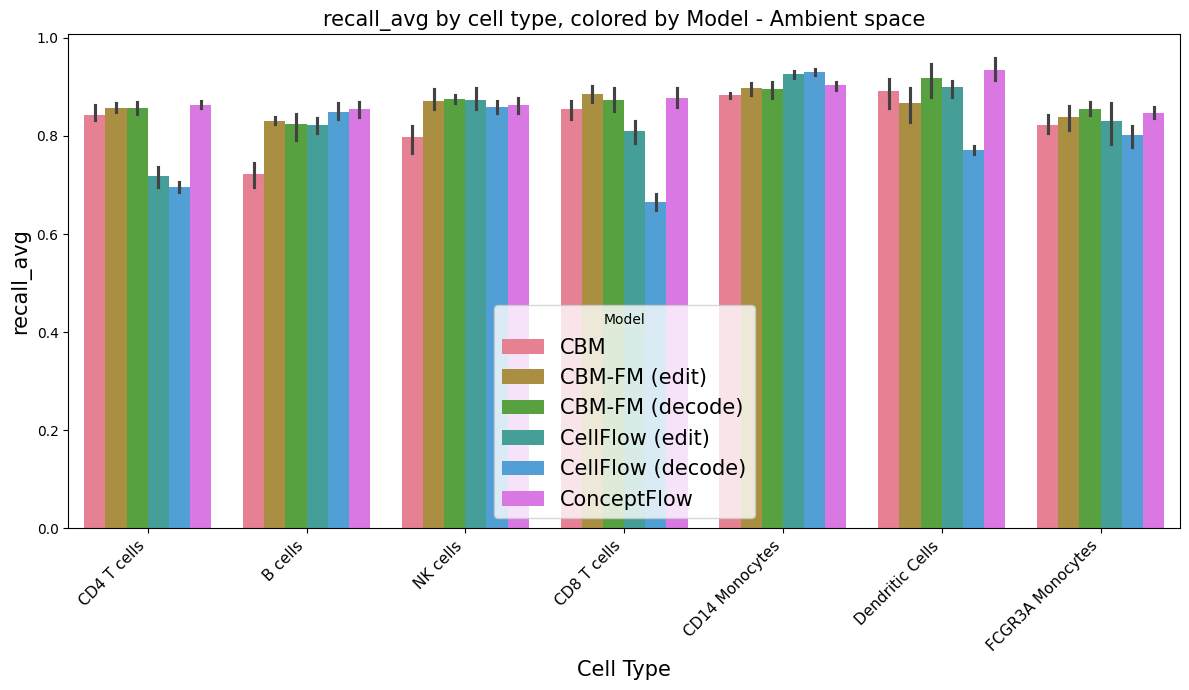

In [ ]:
# Without PCA

metric_name = 'recall_avg'

# Check required columns
required_cols = ['data/intervention_labels', 'model', 'seed', 'mmd_ratio']
missing = [col for col in required_cols if col not in df_res.columns]
if missing:
    raise ValueError(f"Missing columns in df_res: {missing}")

# Aggregate over seeds: mean and std of mmd_ratio for each (cell type, model) pair
plot_df = df_res.groupby(['data/intervention_labels', 'model']).agg({'mmd_ratio': ['mean', 'std']}).reset_index()

plt.figure(figsize=(12,7))
ax = sns.barplot(
    data=df_res,
    x='data/intervention_labels',
    y=metric_name,
    estimator="mean",
    hue='model',
    palette='husl',
 )

plt.title(f'{metric_name} by cell type, colored by Model - Ambient space', fontsize=15)
plt.ylabel(f'{metric_name}', fontsize=15)
plt.xlabel('Cell Type', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.legend(title='Model', fontsize=15)
plt.tight_layout()
plt.show()